In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "SimHei" #解决中文乱码问题
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#获取数据
df_train = pd.read_csv('../data_format1/train_format1.csv')
df_test = pd.read_csv('../data_format1/test_format1.csv')
user_info = pd.read_csv('../data_format1/user_info_format1.csv')
user_log = pd.read_csv('../data_format1/user_log_format1.csv').rename(columns={'seller_id':'merchant_id'})

In [3]:
#数据处理
user_info['age_range'].fillna(-1,inplace=True)
user_info['gender'].fillna(2,inplace=True)  #2和null代表性别不确定
user_log['brand_id'].fillna(-1,inplace=True)

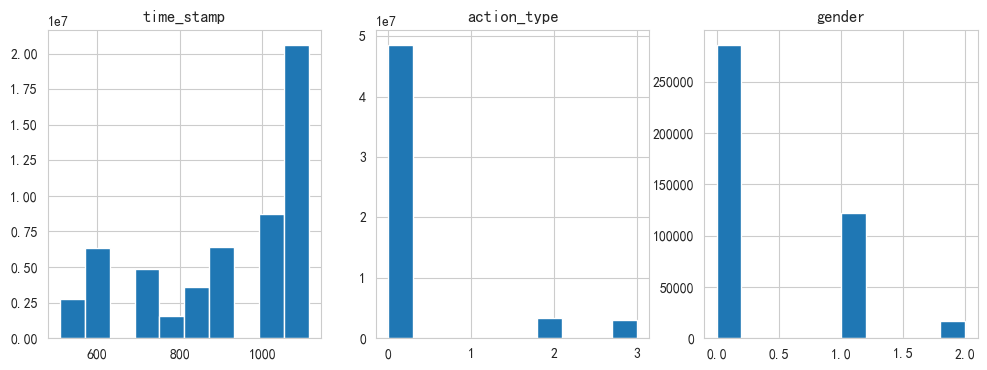

In [4]:
#特征值的分布
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(user_log['time_stamp']) #time_stamp 购买时间（格式：mmdd）
plt.title('time_stamp')
plt.subplot(1,3,2)
plt.hist(user_log['action_type'])
plt.title('action_type') #action_type包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹
plt.subplot(1,3,3)
plt.hist(user_info['gender']) #gender用户性别。0表示女性，1表示男性，2和NULL表示未知
plt.title('gender')
plt.show()

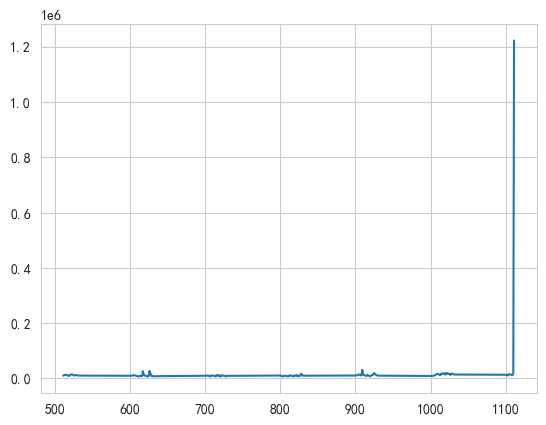

time_stamp
1111    1223354
909       30908
626       26548
617       25801
1021      20155
925       19067
1018      18188
1016      17770
1110      17249
1028      17082
Name: action_type, dtype: int64

In [5]:
#按time_stamp看一下每一天产生了多少条user_log
plt.plot(user_log[user_log['action_type']==2].groupby('time_stamp').count()['action_type'])
plt.show()
user_log[user_log['action_type']==2].groupby('time_stamp').count()['action_type'].sort_values(ascending=False).head(10)

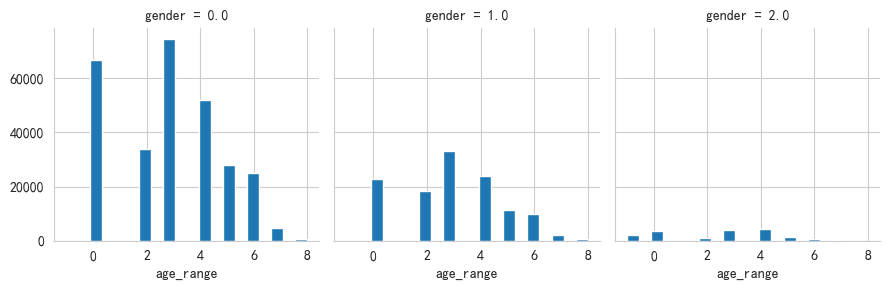

In [6]:
#年龄和性别的联合分布
g = sns.FacetGrid(user_info, col='gender')  #FacetGrid(data, row, col, hue, height, aspect, palette, ...)
g.map(plt.hist, 'age_range', bins=20)#plt.hist画直方图，age为横坐标

In [7]:
#特征工程
temp=user_log.groupby(by=['user_id','merchant_id'])
feature=temp.count().reset_index()[['user_id','merchant_id','item_id']]
#一个人在一家店留下了多少记录
feature.rename(columns={'item_id':'action_times'},inplace=True)
#统计点击次数、购买次数、收藏次数、添加购物车次数
action_temp=user_log.groupby(by=['user_id','merchant_id','action_type']).count().reset_index()
#统计action_type中的四种操作各出现了多少次。
feature=pd.merge(feature,action_temp[action_temp['action_type']==0][['user_id','merchant_id','item_id']],on=['user_id','merchant_id'],how='left')
feature=pd.merge(feature,action_temp[action_temp['action_type']==1][['user_id','merchant_id','cat_id']],on=['user_id','merchant_id'],how='left')
feature=pd.merge(feature,action_temp[action_temp['action_type']==2][['user_id','merchant_id','brand_id']],on=['user_id','merchant_id'],how='left')
feature=pd.merge(feature,action_temp[action_temp['action_type']==3][['user_id','merchant_id','time_stamp']],on=['user_id','merchant_id'],how='left')
feature.fillna(0, inplace=True)
feature.rename(columns={'item_id':'click','cat_id':'cart','brand_id':'buy','time_stamp':'favorite'},inplace=True)
feature=feature.astype({'click':'int64','cart':'int64','buy':'int64','favorite':'int64'})
feature = feature.astype({'click': 'int64', 'cart': 'int64', 'buy': 'int64', 'favorite': 'int64'})
#筛选用户对某个商家的time_stamp出现的不重复次数
time_temp = temp['time_stamp'].nunique().reset_index()
feature = pd.merge(feature, time_temp, on=['user_id', 'merchant_id'], how='left')
#在双十一以外的日子有购买记录，就将not1111变量设置为1
time_temp_2=user_log[(user_log['time_stamp']!=1111) & (user_log['action_type']==2)][['user_id','merchant_id']].drop_duplicates()
time_temp_2['not1111']=1
feature=pd.merge(feature,time_temp_2,on=['user_id','merchant_id'],how='left')
feature.fillna(0, inplace=True)
feature=feature.astype({'not1111':'int64'})
#统计用户在商家这边操作的商品数目
item_temp=temp['item_id'].nunique().reset_index()

feature=pd.merge(feature,item_temp,on=['user_id','merchant_id'],how='left')
feature.fillna(0, inplace=True)
feature.rename(columns={'item_id':'item_num'},inplace=True)
feature=feature.astype({'item_num':'int64'})
#用户在某个商家操作了几种商品？
cat_temp=temp['cat_id'].nunique().reset_index()

feature=pd.merge(feature,cat_temp,on=['user_id','merchant_id'],how='left')
feature.fillna(0, inplace=True)
feature.rename(columns={'cat_id':'cat_num'},inplace=True)
feature=feature.astype({'cat_num':'int64'})

#用户在某个商家操作了几个品牌的商品？
brand_temp=temp['brand_id'].nunique().reset_index()

feature=pd.merge(feature,brand_temp,on=['user_id','merchant_id'],how='left')
feature.fillna(0, inplace=True)
feature.rename(columns={'brand_id':'brand_num'},inplace=True)
feature=feature.astype({'brand_num':'int64'})
#把user_info的信息加进去
feature=pd.merge(feature,user_info,on=['user_id'],how='left')
feature=feature.astype({'age_range':'int64','gender':'int64'})

In [8]:
feature.to_csv('feature.csv')

In [9]:
#整理数据集
train_test = pd.merge(df_train,feature,on=['user_id','merchant_id'],how='left')
pred = pd.merge(df_test,feature,on=['user_id','merchant_id'],how='left')
#以7:3的比例分割训练集和测试集，并分出特征和标签。
train = train_test.sample(frac=0.7)
X_train = train.drop(['user_id','merchant_id','label'], axis=1)#训练集特征
Y_train = train['label']#训练集类标签
test = pd.concat([train_test, train, train]).drop_duplicates(keep=False)#测试集是在train_test但不在train里的数据
X_test = test.drop(['user_id','merchant_id','label'], axis=1)#测试集特征
Y_test = test['label']
X_pred = pred.drop(['user_id','merchant_id','prob'], axis=1)

X_train.shape, Y_train.shape, X_test.shape

((182605, 12), (182605,), (78259, 12))

In [10]:
#决策树
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

96.65

In [11]:
# 逻辑回归模型
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

logreg = LogisticRegression(random_state=1,solver='newton-cg')#,class_weight='balanced')
logreg.fit(X_train, Y_train)#用训练集特征和对应的类标签拟合逻辑回归模型
Y_pred = logreg.predict(X_test)  # logreg.predict_proba(X_test)[:,1]
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(acc_log)

#使用sklearn库里面的交叉验证函数获取预测准确率分数
scores = model_selection.cross_val_score(logreg,X_train,Y_train,cv=3)
#使用交叉验证分数的平均值作为最终的准确率
print("准确率为: ",scores.mean())

93.9
准确率为:  0.9389501929459901


In [12]:
#随机森林
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

96.65

In [13]:
#预测logreg、random_forest、decision_tree
Y_tpred=logreg.predict_proba(X_pred)
Y_tpred

array([[0.95372269, 0.04627731],
       [0.89110057, 0.10889943],
       [0.94645585, 0.05354415],
       ...,
       [0.89210034, 0.10789966],
       [0.95343092, 0.04656908],
       [0.95229412, 0.04770588]])

In [14]:
df_test['prob']=Y_tpred[:,1]
df_test.to_csv('.\submission.csv',index = False)